#TODO 
* scrape any car data from ss.com
* clean up prices as numerics
* group by make and model
* plot the data - pricing for sure
* if you do more advanced analysis that also could be used for the final project

* for those who want scraping part of final project
* scrape data from somewhere else - maybe Lithuanian ss.com or wikipedia?

In [1]:
import requests
import time 
import pandas as pd
 
from bs4 import BeautifulSoup

In [2]:
url = "https://www.ss.com/en/transport/cars/lexus/"
url

'https://www.ss.com/en/transport/cars/lexus/'

In [3]:
req = requests.get(url)
req.status_code 

200

In [4]:
soup = BeautifulSoup(req.text, 'lxml')
soup.title

<title>SS.COM Cars - Lexus, Prices - Advertisements</title>

In [5]:
def getColList(soup, default_columns = ("description","url")):
    column_list = list(default_columns)
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]]
    column_list += headcolumns
    return column_list

In [6]:
column_names = getColList(soup)
column_names

['description', 'url', 'Model', 'Year', 'Volume', 'Run', 'Price']

In [7]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [8]:
def getRow(row,colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3:
        print("Hmm bad row")
        return rowDict
    rowDict[colist[0]] = row_tds[2].text
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [9]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [10]:
def getDFfromURL(url):
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows)

In [11]:
apt_rows = getRowList(soup)
len(apt_rows)

30

In [12]:
row_ads = getRows(apt_rows)
row_ads[:5]

[{'description': 'Pārdod Lexus GS 300 , automāts, bagātīga komplektācija, sēdekļi elektriskie ',
  'url': 'https://ss.com/msg/en/transport/cars/lexus/gs/bfgkf.html',
  'Model': 'GS',
  'Year': '2006',
  'Volume': '3.0',
  'Run': '269 thd.',
  'Price': '3,800  €'},
 {'description': 'Pārdod Lexus Is220 130 KW\r\nAuto labā stāvoklī\r\nMelns ādas salons \r\n2 Atslēga',
  'url': 'https://ss.com/msg/en/transport/cars/lexus/is/dpxjf.html',
  'Model': 'IS',
  'Year': '2008',
  'Volume': '2.2D',
  'Run': '-',
  'Price': '4,650  €'},
 {'description': 'Lexus is200, automats, benzins. \r\nAuto tiesham laba tehniska un vizuala stav',
  'url': 'https://ss.com/msg/en/transport/cars/lexus/is/bdjoj.html',
  'Model': 'IS',
  'Year': '2003',
  'Volume': '2.0',
  'Run': '220 thd.',
  'Price': '1,950  €'},
 {'description': 'Pārdošanā is220D 130kw jauna tehniska apskate, nodoklis nomaksāts, jauns yua',
  'url': 'https://ss.com/msg/en/transport/cars/lexus/is/dxkof.html',
  'Model': 'IS',
  'Year': '2006',
  

In [13]:
dtemp = pd.DataFrame(row_ads)
dtemp.head()

,description,url,Model,Year,Volume,Run,Price
0,"Pārdod Lexus GS 300 , automāts, bagātīga kompl...",https://ss.com/msg/en/transport/cars/lexus/gs/...,GS,2006,3.0,269 thd.,"3,800 €"
1,Pārdod Lexus Is220 130 KW\r\nAuto labā stāvokl...,https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2008,2.2D,-,"4,650 €"
2,"Lexus is200, automats, benzins. \r\nAuto tiesh...",https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2003,2.0,220 thd.,"1,950 €"
3,"Pārdošanā is220D 130kw jauna tehniska apskate,...",https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2006,2.2D,-,"3,900 €"
4,Машина в хорошем состояние. На 160 000 была за...,https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2008,2.5,180 thd.,"5,600 €"


In [14]:
dtemp.shape

(30, 7)

In [15]:
anchors = soup.find_all("a")
len(anchors)

120

In [16]:
navs = [anchor for anchor in anchors if anchor.get("name") == "nav_id"]
len(navs)

9

In [17]:
afterpage = navs[0]['href'].split("/page")[-1]
afterpage

'8.html'

In [18]:
beforedot = afterpage.split(".html")[0]
beforedot

'8'

In [19]:
lastpage = int(beforedot)
lastpage

8

In [20]:
def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url]
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    prevanchor = soup.find('a', {"rel":"prev"})
    if prevanchor == None:
        return results 
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

In [21]:
local_urls = getAllLocalUrls(url)
len(local_urls),local_urls,local_urls[-1]

Last page is 8


(8,
 ['https://www.ss.com/en/transport/cars/lexus/',
  'https://www.ss.com/en/transport/cars/lexus/page2.html',
  'https://www.ss.com/en/transport/cars/lexus/page3.html',
  'https://www.ss.com/en/transport/cars/lexus/page4.html',
  'https://www.ss.com/en/transport/cars/lexus/page5.html',
  'https://www.ss.com/en/transport/cars/lexus/page6.html',
  'https://www.ss.com/en/transport/cars/lexus/page7.html',
  'https://www.ss.com/en/transport/cars/lexus/page8.html'],
 'https://www.ss.com/en/transport/cars/lexus/page8.html')

In [22]:
dlast = getDFfromURL(local_urls[-1])
dlast.shape

(15, 7)

In [23]:
def get_all_ads_df(start_url, save_excel_path=None, save_csv_path=None):
    df_list=[]
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        time.sleep(0.3)
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list)
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    if save_csv_path:
        big_df.to_csv(save_csv_path,encoding="utf-8")
    return big_df

In [24]:
lexus_data = get_all_ads_df(url, "lexus_data.xlsx")

Last page is 8
Gathering data from https://www.ss.com/en/transport/cars/lexus/
Gathering data from https://www.ss.com/en/transport/cars/lexus/page2.html
Gathering data from https://www.ss.com/en/transport/cars/lexus/page3.html
Gathering data from https://www.ss.com/en/transport/cars/lexus/page4.html
Gathering data from https://www.ss.com/en/transport/cars/lexus/page5.html
Gathering data from https://www.ss.com/en/transport/cars/lexus/page6.html
Gathering data from https://www.ss.com/en/transport/cars/lexus/page7.html
Gathering data from https://www.ss.com/en/transport/cars/lexus/page8.html


In [25]:
lexus_data.shape

(225, 7)

In [26]:
lexus_data.head()

,description,url,Model,Year,Volume,Run,Price
0,"Pārdod Lexus GS 300 , automāts, bagātīga kompl...",https://ss.com/msg/en/transport/cars/lexus/gs/...,GS,2006,3.0,269 thd.,"3,800 €"
1,Pārdod Lexus Is220 130 KW\r\nAuto labā stāvokl...,https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2008,2.2D,-,"4,650 €"
2,"Lexus is200, automats, benzins. \r\nAuto tiesh...",https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2003,2.0,220 thd.,"1,950 €"
3,"Pārdošanā is220D 130kw jauna tehniska apskate,...",https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2006,2.2D,-,"3,900 €"
4,Машина в хорошем состояние. На 160 000 была за...,https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2008,2.5,180 thd.,"5,600 €"


In [27]:
lexus_info = pd.read_excel("lexus_data.xlsx")
lexus_info.shape

(225, 8)

In [28]:
lexus_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   225 non-null    int64 
 1   description  225 non-null    object
 2   url          225 non-null    object
 3   Model        225 non-null    object
 4   Year         225 non-null    object
 5   Volume       225 non-null    object
 6   Run          225 non-null    object
 7   Price        225 non-null    object
dtypes: int64(1), object(7)
memory usage: 14.2+ KB


In [29]:
lexus_info['Price'] = lexus_info['Price'].str.replace("€","")
lexus_info['Price'] = lexus_info['Price'].str.replace(",","")
lexus_info.Price.head()
lexus_info['Price'] = pd.to_numeric(lexus_info['Price'], errors='coerce')
lexus_info['Price'].describe()

count      189.000000
mean     15573.740741
std      12882.937903
min       1950.000000
25%       5777.000000
50%       9990.000000
75%      22300.000000
max      49990.000000
Name: Price, dtype: float64

In [30]:
lexus_info['Volume'] = pd.to_numeric(lexus_info['Volume'], errors='coerce')

In [31]:
lexus_info.head()

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
0,0,"Pārdod Lexus GS 300 , automāts, bagātīga kompl...",https://ss.com/msg/en/transport/cars/lexus/gs/...,GS,2006,3.0,269 thd.,3800.0
1,1,Pārdod Lexus Is220 130 KW\r\nAuto labā stāvokl...,https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2008,NaN,-,4650.0
2,2,"Lexus is200, automats, benzins. \r\nAuto tiesh...",https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2003,2.0,220 thd.,1950.0
3,3,"Pārdošanā is220D 130kw jauna tehniska apskate,...",https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2006,NaN,-,3900.0
4,4,Машина в хорошем состояние. На 160 000 была за...,https://ss.com/msg/en/transport/cars/lexus/is/...,IS,2008,2.5,180 thd.,5600.0


In [32]:
by_model = lexus_info.groupby('Model').agg({'Volume':['mean','median','min','max','count'],'Price':['mean','median','min','max','count']})
by_model

Volume                                Price                    \
                mean median  min  max count          mean   median      min   
Model                                                                         
120              NaN    NaN  NaN  NaN     0           NaN      NaN      NaN   
Accord      2.000000   2.00  2.0  2.0     1           NaN      NaN      NaN   
Another          NaN    NaN  NaN  NaN     0           NaN      NaN      NaN   
CT          1.800000   1.80  1.8  1.8     1  12755.642857  12250.0   9850.0   
Civic       1.800000   1.80  1.8  1.8     1           NaN      NaN      NaN   
ES          3.000000   3.00  3.0  3.0     1  35162.500000  44950.0   3250.0   
GS          2.937500   3.00  2.5  3.5    24  11917.352941   6797.5   2300.0   
GX          4.650000   4.65  4.6  4.7     2  22125.000000  22125.0  14750.0   
Highlander  3.300000   3.30  3.3  3.3     1           NaN      NaN      NaN   
IS          2.435484   2.50  2.0  3.0    31   6785.576923   5550.0   1950.0   
LS          4.000000   4.45  2.5  4.6     4  10331.666667   9595.0   4000.0   
LX          5.700000   5.70  5.7  5.7     1  49900.000000  49900.0  49900.0   
NX          2.166667   2.00  2.0  2.5     3  33106.666667  33500.0  21500.0   
RC          3.500000   3.50  3.5  3.5     1  25500.000000  25500.0  25500.0   
RX          2.965000   3.00  2.0  3.5    20  16559.142857  13100.0   3800.0   
SC          4.300000   4.30  4.3  4.3     1  12500.000000  12500.0  12500.0   
UX               NaN    NaN  NaN  NaN     0  41347.500000  39850.0  35700.0   

                           
                max count  
Model                      
120             NaN     0  
Accord          NaN     0  
Another         NaN     0  
CT          16999.0    14  
Civic           NaN     0  
ES          47500.0     4  
GS          34000.0    34  
GX          29500.0     2  
Highlander      NaN     0  
IS          22500.0    52  
LS          18900.0     6  
LX          49900.0     1  
NX          47000.0    21  
RC          25500.0     1  
RX          47900.0    49  
SC          12500.0     1  
UX          49990.0     4

In [33]:
lexus_info.tail(10)

,Unnamed: 0,description,url,Model,Year,Volume,Run,Price
215,5,Продаю Lexus UX 250h Premium+ (177hp) в отличн...,https://ss.com/msg/en/transport/cars/lexus/ux/...,UX,2020,NaN,21 thd.,35700.0
216,6,"Lexus CT 200H, Hybrid. Оригинальный пробег . Д...",https://ss.com/msg/en/transport/cars/lexus/ct/...,CT,2012,NaN,97 thd.,13200.0
217,7,"Lexus CT 200h, hibrīda dzinējs, balta perlamut...",https://ss.com/msg/en/transport/cars/lexus/ct/...,CT,2011,NaN,254 thd.,10990.0
218,8,Kabriolets ar dzelzs jumtu. Motors 4.3 L 3Uz-F...,https://ss.com/msg/en/transport/cars/lexus/sc/...,SC,2002,4.3,230 thd.,12500.0
219,9,Pārdodu Lexus ES 300h Executive Plus komplektā...,https://ss.com/msg/en/transport/cars/lexus/es/...,ES,2019,NaN,37 thd.,45000.0
220,10,F-sport 3.5i 190kw. 4x4 automats labā tehniskā...,https://ss.com/msg/en/transport/cars/lexus/rc/...,RC,2016,3.5,17 thd.,25500.0
221,11,"Lexus LX 570 V8 A/t. 2012. gada. 5.7l benzīns,...",https://ss.com/msg/en/transport/cars/lexus/lx/...,LX,2012,5.7,182 thd.,49900.0
222,12,Редкий Lexus Es300 3.0 бенз/газ. Полный аналог...,https://ss.com/msg/en/transport/cars/lexus/es/...,ES,1998,3.0,116 thd.,3250.0
223,13,"Pārdod kompaktu un ekonomisku hibrīdauto, ceļa...",https://ss.com/msg/en/transport/cars/lexus/ct/...,CT,2011,NaN,171 thd.,10800.0
224,14,"Lexus Es300H Limited Edition 2021.g. 2, 5 Hybr...",https://ss.com/msg/en/transport/cars/lexus/es/...,ES,2021,NaN,59 thd.,47500.0


In [34]:
grouped_by_model = lexus_info.groupby(by="Model")['Price'].agg(["count", "min", "max", "mean", ])
grouped_by_model

,count,min,max,mean
Model,,,,
120,0,NaN,NaN,NaN
Accord,0,NaN,NaN,NaN
Another,0,NaN,NaN,NaN
CT,14,9850.0,16999.0,12755.642857
Civic,0,NaN,NaN,NaN
ES,4,3250.0,47500.0,35162.500000
GS,34,2300.0,34000.0,11917.352941
GX,2,14750.0,29500.0,22125.000000
Highlander,0,NaN,NaN,NaN


array([[<AxesSubplot: title={'center': 'count'}>,
        <AxesSubplot: title={'center': 'min'}>],
       [<AxesSubplot: title={'center': 'max'}>,
        <AxesSubplot: title={'center': 'mean'}>]], dtype=object)

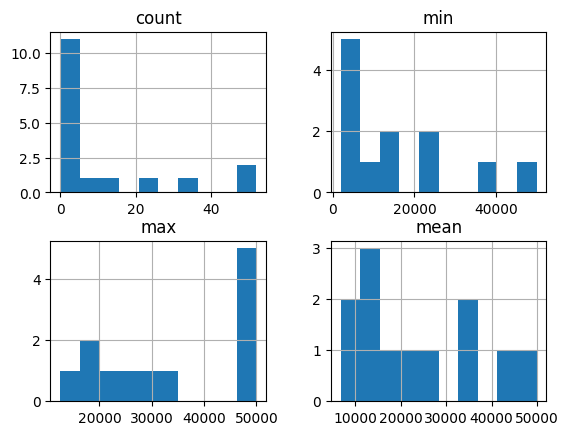

In [35]:
grouped_by_model.hist()

<AxesSubplot: xlabel='Model'>

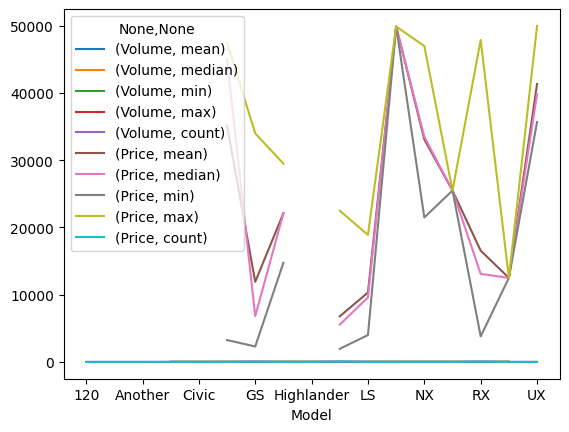

In [36]:
by_model.plot()